# Using Polya Gamma Auxiliary Variables for Binary Classification

## Overview

In this notebook, we'll demonstrate how to use Polya-Gamma auxiliary variables to do efficient inference for Gaussian Process binary classification as in reference [1]. We will also use natural gradient descent, as described in more detail in the [Natural gradient descent](./Natural_Gradient_Descent.ipynb) tutorial.


[1] Florian Wenzel, Theo Galy-Fajou, Christan Donner, Marius Kloft, Manfred Opper. [Efficient Gaussian process classification using Pòlya-Gamma data augmentation](https://arxiv.org/abs/1802.06383). Proceedings of the AAAI Conference on Artificial Intelligence. 2019.

## Polya-Gamma Augmentation

When a Gaussian Process prior is paired with a Gaussian likelihood inference can be done exactly with a simple closed form expression.
Unfortunately this attractive feature does not carry over to non-conjugate likelihoods like the Bernoulli likelihood that arises in the context of binary classification.
Variational inference offers a general strategy for dealing with non-conjugate likelihoods; see the [corresponding tutorial](./Non_Gaussian_Likelihoods.ipynb).

Another possible strategy is to introduce additional latent variables that restore conjugacy. 
This is the strategy we follow here. In particular we are going to introduce a Polya-Gamma auxiliary variable for each data point in our training dataset. 
The [Polya-Gamma](https://arxiv.org/abs/1205.0310) distribution $\rm{PG}$ is a univariate distribution with support on the positive real line. 
In our context it is interesting because if $\omega_i$ is distributed according to $\rm{PG}(0,1)$ then the logistic likelihood $\sigma(\cdot)$ for data point $(x_i, y_i)$ can be represented as

\begin{align}
\sigma(y_i f_i) = \frac{1}{1 + \exp(-y_i f_i)} = \tfrac{1}{2} \mathbb{E}_{\omega_i \sim \rm{PG}(0,1)} \left[ \exp \left(\tfrac{1}{2} y_i f_i - \tfrac{\omega_i}{2} f_i^2 \right) \right]
\end{align}

where $y_i \in \{-1, 1\}$ is the binary label of a particular data point
and $f_i$ is the Gaussian Process prior evaluated at input $x_i$. 
The crucial point here is that $f_i$ appears quadratically in the exponential within the expectation. 
In order words, conditioned on $\omega_i$, we can integrate out $f_i$ exactly, just as if we were doing regression with a Gaussian likelihood. For more details please see the original reference. 

## Setup

In [1]:
import tqdm
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

# Make plots inline
%matplotlib inline

For this example notebook, we'll create a simple artificial dataset.

In [4]:
import os
from math import floor

# this is for running the notebook in our testing framework
smoke_test = ('CI' in os.environ)

N = 100
X = torch.linspace(-1., 1., N)
probs = (torch.sin(X * math.pi).add(1.).div(2.))
y = torch.distributions.Bernoulli(probs=probs).sample()
X = X.unsqueeze(-1)

train_n = int(floor(0.8 * N))
indices = torch.randperm(N)
train_x = X[indices[:train_n]].contiguous()
train_y = y[indices[:train_n]].contiguous()

test_x = X[indices[train_n:]].contiguous()
test_y = y[indices[train_n:]].contiguous()

if torch.cuda.is_available():
    train_x, train_y, test_x, test_y = train_x.cuda(), train_y.cuda(), test_x.cuda(), test_y.cuda()

Let's plot our artificial dataset. Note that here the binary labels are 0/1-valued; we will need to be careful to translate between this representation and the -1/1 representation that is most natural in the context of Polya-Gamma augementation.

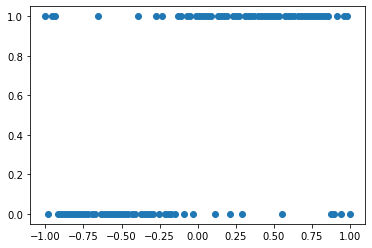

In [5]:
plt.plot(X.squeeze(-1), y, 'o')

The following steps create the dataloader objects. See the [SVGP regression notebook](./SVGP_Regression_CUDA.ipynb) for details.

In [6]:
from torch.utils.data import TensorDataset, DataLoader
train_i = torch.arange(0, len(train_x), device=train_x.device)
train_dataset = TensorDataset(train_i, train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=100000000, shuffle=False)

test_dataset = TensorDataset(test_x, test_y)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

## SVGP models for NGD

We define a Bernoulli likelihood that leverages Polya-Gamma augementation.

In [276]:
class PGLikelihood(gpytorch.likelihoods._OneDimensionalLikelihood):
    def __init__(self, num_data):
        super().__init__()
        self.register_buffer("c", torch.zeros(num_data))
        self.register_buffer("mean", torch.zeros(num_data))
        self.register_buffer("variance", torch.zeros(num_data))

    def expected_log_prob(self, target, input, indices, *args, **kwargs):
        mean, variance = input.mean, input.variance
        
        # Set targets to be -1, 1
        target = target.to(mean.dtype).mul(2.).sub(1.)
        
        # PG auxiliary variable
        c = torch.sqrt(variance + mean.pow(2)).detach()
        omega = torch.tanh(0.5 * c) / (2. * c)
        
        # Store the PG variable
        with torch.no_grad():
            self.c[indices] = c
            self.mean[indices] = mean
            self.variance[indices] = variance
        
        # Expected log likelihood
        res = 0.5 * target * mean - 0.5 * omega * (mean.pow(2) + variance)
        res = res.sum(dim=-1)
        return res
    
    def forward(self, function_samples):
        return torch.distributions.Bernoulli(logits=function_samples)
    
    def marginal(self, function_dist):
        prob_lambda = lambda function_samples: self.forward(function_samples).probs
        probs = self.quadrature(prob_lambda, function_dist)
        return torch.distributions.Bernoulli(probs=probs)

    
class GPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = gpytorch.variational.NaturalVariationalDistribution(inducing_points.size(0))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super(GPModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        
    @property
    def c(self):
        return self.raw_c.exp()
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


inducing_points = torch.linspace(-2., 2., 30, dtype=train_x.dtype, device=train_x.device).unsqueeze(-1)
model = GPModel(inducing_points=inducing_points)
model.covar_module.base_kernel.initialize(lengthscale=0.2)
likelihood = PGLikelihood(num_data=len(train_x))

if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()

### Difference #2: Two optimizers - one for the variational parameters; one for the hyperparameters

NGD steps only update the variational parameters. Therefore, we need two separate optimizers: one for the variational parameters (using NGD) and one for the other hyperparameters (using Adam or whatever you want).

Some things to note about the NGD variational optimizer:

- **You must use `gpytorch.optim.NGD` as the variational NGD optimizer!** Adaptive gradient algorithms will mess up the natural gradient steps. (Any stochastic optimizer works for the hyperparameters.)
- **Use a large learning rate for the variational optimizer.** Typically, 0.1 is a good learning rate.

In [277]:
variational_ngd_optimizer = gpytorch.optim.NGD(model.variational_parameters(), num_data=train_y.size(0), lr=0.1)

hyperparameter_optimizer = torch.optim.Adam([
    {'params': model.hyperparameters()},
    {'params': likelihood.parameters()},
], lr=0.01)

### Difference #3: The updated training loop

In the training loop, we have to update both optimizers (`variational_ngd_optimizer` and `hyperparameter_optimizer`). 

In [278]:
model.train()
likelihood.train()
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_y.size(0))

num_epochs = 1 if smoke_test else 100
epochs_iter = tqdm.notebook.tqdm(range(num_epochs), desc="Epoch")
for i in epochs_iter:
    minibatch_iter = tqdm.notebook.tqdm(train_loader, desc="Minibatch", leave=False)
    
    for i_batch, x_batch, y_batch in minibatch_iter:
        ### Perform NGD step to optimize variational parameters
        variational_ngd_optimizer.zero_grad()
        hyperparameter_optimizer.zero_grad()
        
        output = model(x_batch)
        loss = -mll(output, y_batch, indices=i_batch)
        minibatch_iter.set_postfix(loss=loss.item())
        loss.backward()
        variational_ngd_optimizer.step()
        hyperparameter_optimizer.step()

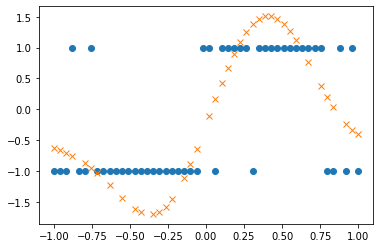

In [279]:
plt.plot(X.squeeze(-1), y.mul(2.).sub(1.), 'o')
plt.plot(train_x.squeeze(-1).cpu(), likelihood.mean.cpu(), 'x')

In [280]:
model.eval()
likelihood.eval()
means = torch.tensor([0.])
with torch.no_grad():
    nlls = -likelihood.log_marginal(test_y, model(test_x))
    acc = (likelihood(model(test_x)).probs.gt(0.5) == test_y.bool()).float().mean()
print('Test NLL: {}'.format(nlls.mean()))
print('Test Acc: {}'.format(acc.mean()))

Test NLL: 0.4061666429042816
Test Acc: 0.800000011920929


In [281]:
likelihood(model(test_x)).probs.min()

tensor(0.1724, device='cuda:0', grad_fn=<MinBackward1>)

In [282]:
likelihood(model(test_x)).probs.max()

tensor(0.7071, device='cuda:0', grad_fn=<MaxBackward1>)